# Classificando thumbnails com Redes Neurais

Neste script vamos implementar uma solução baseada em Redes Neurais para classificar thumbnails. Ao final o nosso modelo deve saber distinguir thumbnails que sejam do canal Nerdologia, de thumbnails do nosso querido Peixe Babel.

Este código foi utilizado na produção do vídeo "Redes Neurais em PyTorch | Programando em 10 minutos" do canal Peixe Babel: https://youtu.be/Vfzm1-cfLuc

> Lembre-se: Para entender melhor o que fizemos nesse código, acesse o curso da Mila na Alura: <br> https://www.alura.com.br/curso-online-pln-deep-learning

In [1]:
!pip install python-youtube
!pip install dataclasses-json

     |████████████████████████████████| 51kB 6.2MB/s 
     |████████████████████████████████| 51kB 4.7MB/s 
  Created wheel for stringcase: filename=stringcase-1.2.0-cp36-none-any.whl size=3577 sha256=139a1447029b67e20b48f2f61570d2b8b3a9e652d4f702e75b57f600c346e36f
  Stored in directory: /root/.cache/pip/wheels/a0/16/a0/16e2c81dbd47503b5a35583dfabde5a93b4cf98dbf0033dad5
Successfully built stringcase
ERROR: chainer 6.5.0 has requirement typing-extensions<=3.6.6, but you'll have typing-extensions 3.7.4.1 which is incompatible.
  Found existing installation: typing-extensions 3.6.6
    Uninstalling typing-extensions-3.6.6:
      Successfully uninstalled typing-extensions-3.6.6


In [0]:
from pyyoutube import Api

import skimage
from skimage import io, exposure
import matplotlib.pyplot as plt
import numpy as np

### API Key

Coloque aqui a sua chave da API do YouTube. <br>
Ela pode ser gerada associada à sua conta do Google através desse link:
https://console.developers.google.com/apis/credentials 

In [0]:
api_key = '' ##Cole aqui a sua chave
api = Api(api_key=api_key)

## Coleta dos dados

(180, 320, 3) 0.0 1.0


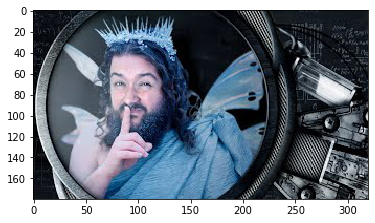

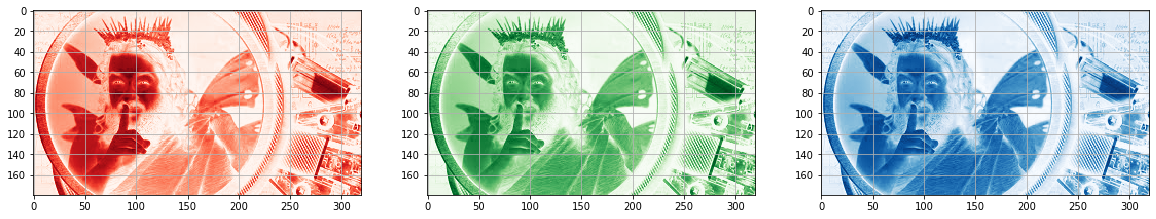

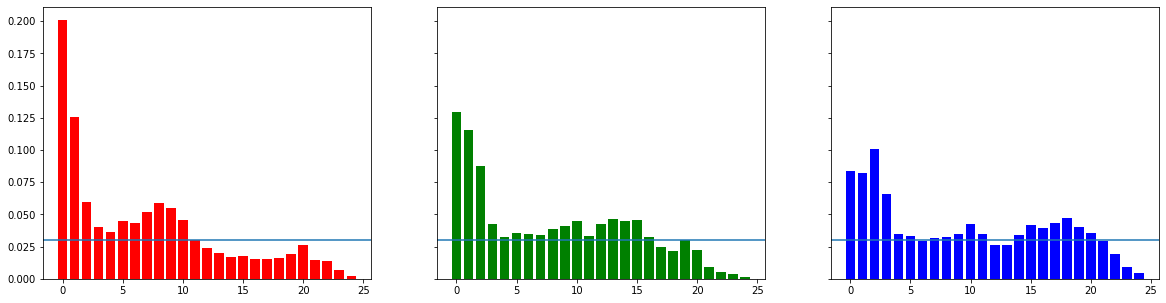

In [4]:
# https://www.youtube.com/watch?v=ucRzA87hiE0  ## Nerdologia
# https://www.youtube.com/watch?v=a6StZPu-16I  ## Peixe Babel
for url in ['ucRzA87hiE0']:
  
  ## Acessando o link da thumbnail pela API do YouTube
  video_by_id = api.get_video_by_id(video_id=url)
  thumbnail_url = video_by_id.items[0].to_dict()['snippet']['thumbnails']['medium']['url']

  ## Lendo a imagem
  img = skimage.img_as_float(io.imread(thumbnail_url))
  plt.figure()
  plt.imshow(img)

  ## Imprimindo canais separados da imagem (RGB - vermelho, verde, azul)
  print(img.shape, np.min(img[:,:,0]), np.max(img[:,:,0]))
  fig, axs = plt.subplots(1, 3, figsize=(20, 5))
  axs[0].imshow(img[:,:,0], cmap='Reds')
  axs[0].grid(True)
  axs[1].imshow(img[:,:,1], cmap='Greens')
  axs[1].grid(True)
  axs[2].imshow(img[:,:,2], cmap='Blues')
  axs[2].grid(True)

  ## Calculando e imprimindo os histogramas de cor
  nbins = 25
  histograms = [exposure.histogram(img[:,:,i], nbins=nbins, normalize=True)[0] for i in range(img.shape[-1])]
  fig, axs = plt.subplots(1, 3, figsize=(20, 5), sharey= True)
  axs[0].bar(np.arange(len(histograms[0])), histograms[0], color='r')
  axs[0].axhline(0.03, 0, 50)
  axs[1].bar(np.arange(len(histograms[1])), histograms[1], color='g')
  axs[1].axhline(0.03, 0, 50)
  axs[2].bar(np.arange(len(histograms[2])), histograms[2], color='b')
  axs[2].axhline(0.03, 0, 50)


## Coletando Thumbnails

Nesta célula é realizada a coleta dos últimos 200 vídeos dos canais Nerdologia e Peixe Babel.

In [0]:
channels = ["nerdologia", "CanalPeixeBabel"]

all_url = {}
all_histograms = {}

nbins = 25
for channel in channels:

  ## Acessando playlist principal do canal (uploads)
  channel_by_id = api.get_channel_info(channel_name=channel)
  playlist_uploads = channel_by_id.items[0].to_dict()['contentDetails']['relatedPlaylists']['uploads']

  ## Coletando o id dos últimos ## 200 ## vídeos de cada canal (count)
  playlist_item_by_playlist = api.get_playlist_items(playlist_id=playlist_uploads, count=200)
  
  all_url[channel] = []
  all_histograms[channel] = []
  
  for k, item in enumerate(playlist_item_by_playlist.items):
    try:
      ## Coletando informação da thumbnail de cada vídeo
      video_id = item.snippet.resourceId.videoId
      video_by_id = api.get_video_by_id(video_id=video_id)
      
      thumbnail_url = video_by_id.items[0].to_dict()['snippet']['thumbnails']['medium']['url']
      
      ## Lendo a imagem e extraindo os histogramas
      img = skimage.img_as_float(io.imread(thumbnail_url))
      histograms = [exposure.histogram(img[:,:,i], nbins=nbins, normalize=True)[0] for i in range(img.shape[-1])]
      all_histograms[channel].append(histograms)

      all_url[channel].append(thumbnail_url)
    except:
      print(k)

  

Caso seja necessário, use a célula a seguir para salvar os histogramas e os links das thumbnails. <br>
**Existe um limite diário de chamadas da API**, salvar os dados vai te dar mais liberdade para experimentar com o seu código :)

In [0]:
np.savez_compressed('hitograms', hist=all_histograms)
np.savez_compressed('thumbnail_url', url=all_url)

Jeito ~~preguiçoso~~ rápido de criar uma lista com os links das thumbnails para alimentar o dataset que criaremos em seguda.

In [6]:
all_url.keys()
url_list = []
url_list.extend(all_url['nerdologia'])
url_list.extend(all_url['CanalPeixeBabel'])

label_list = len(all_url['nerdologia']) * [0]
label_list.extend(len(all_url['CanalPeixeBabel']) * [1])

len(url_list), len(label_list)

(400, 400)

### Criação do Dataset (PyTorch)

In [0]:
import torch
from torch import nn, optim

from torch.utils.data import Dataset, DataLoader
from torch.utils.data import SubsetRandomSampler
from torchvision import transforms

if torch.cuda.is_available():
  device = torch.device('cuda')
else:
  device = torch.device('cpu')

In [0]:
class ThumbData(Dataset):
  def __init__(self, all_url, label_list, nbins):
    self.all_url = all_url
    self.nbins   = nbins
    self.labels  = label_list

  def __len__(self):
    return len(self.all_url)

  def __getitem__(self, idx):

    thumbnail_url = self.all_url[idx]
    img = skimage.img_as_float(io.imread(thumbnail_url))

    histograms = [exposure.histogram(img[:,:,i], nbins=self.nbins, normalize=True)[0] for i in range(img.shape[-1])]

    return np.asarray(histograms).ravel(), self.labels[idx]

data = ThumbData(url_list, label_list, nbins)

train_size = int(0.75*len(data))
idx  = torch.randperm(len(data))
train_sampler = SubsetRandomSampler(idx[0:train_size]) 
test_sampler = SubsetRandomSampler(idx[train_size:])

train_loader = DataLoader(data, sampler=train_sampler,
                          batch_size=10, num_workers=4)

test_loader  = DataLoader(data, sampler=test_sampler,
                          batch_size=10, num_workers=4)

## Rede Neural em PyTorch

Implementando a arquitetura

In [33]:
class MinhaRede(nn.Module):

  def __init__(self, tam_entrada):

    super(MinhaRede, self).__init__()

    # Definir a arquitetura
    self.rede = nn.Sequential(
        nn.Linear(tam_entrada, 32),
        nn.ReLU(),
        nn.Linear(32, 2)
    )

  def forward(self, thumbnail):

    # Fluxo de passagem do dado
    saida = self.rede(thumbnail)
    return saida

tam_entrada = 3 * 25
rede = MinhaRede(tam_entrada).to(device).double()

print(rede)

MinhaRede(
  (rede): Sequential(
    (0): Linear(in_features=75, out_features=32, bias=True)
    (1): ReLU()
    (2): Linear(in_features=32, out_features=2, bias=True)
  )
)


### Loss e Otimizador

In [0]:
optimizer = optim.Adam(rede.parameters(), lr=1e-3, weight_decay=5e-4)
criterion = nn.CrossEntropyLoss().to(device)

### Fluxo de Treinamento

In [0]:
from sklearn import metrics 

def forward(mode, loader):

  if mode == 'train':
    rede.train()
  else:
    rede.eval()
  
  epoch_loss = []
  pred_list, label_list = [], []

  for data, label in loader:

    data = data.to(device)
    label = label.to(device)

    optimizer.zero_grad()
    out = rede(data)
    # print(out.size(), label.size())
    loss = criterion(out, label)
    epoch_loss.append(loss.cpu().data)
  
    pred = out.data.max(dim=1)[1].cpu().numpy()
    # print(label)
    pred_list.append(pred)
    label_list.append(label.cpu().numpy())

    if mode == 'train':
      loss.backward()
      optimizer.step()

  epoch_loss = np.asarray(epoch_loss)
  pred_list = np.asarray(pred_list).ravel()
  label_list = np.asarray(label_list).ravel()

  acc = metrics.accuracy_score(pred_list, label_list)

  print(mode, 'Loss:', epoch_loss.mean(), '+/-', epoch_loss.std(), 'Accuracy:', acc)

In [35]:
num_epochs = 20
for i in range(num_epochs):
  forward('train', train_loader)
  forward('test', test_loader)
  print('--------------------------------')

train Loss: 0.687272391575936 +/- 0.013565538894688653 Accuracy: 0.5033333333333333
test Loss: 0.6743141450782371 +/- 0.009590362900019961 Accuracy: 0.63
--------------------------------
train Loss: 0.6650645269375858 +/- 0.012238473690021156 Accuracy: 0.7266666666666667
test Loss: 0.6482095734581738 +/- 0.010594938175410148 Accuracy: 0.82
--------------------------------
train Loss: 0.6280655738597508 +/- 0.019973371208718768 Accuracy: 0.9233333333333333
test Loss: 0.6049650788347168 +/- 0.030392187972640965 Accuracy: 0.89
--------------------------------
train Loss: 0.5682342597828018 +/- 0.031341990786393915 Accuracy: 0.9066666666666666
test Loss: 0.5411909751525082 +/- 0.042487258968637594 Accuracy: 0.87
--------------------------------
train Loss: 0.4976960899664195 +/- 0.06197274671616737 Accuracy: 0.9066666666666666
test Loss: 0.47938374776561804 +/- 0.04902447301533794 Accuracy: 0.89
--------------------------------
train Loss: 0.4308657230165109 +/- 0.046638962882250834 Accura

### Predição

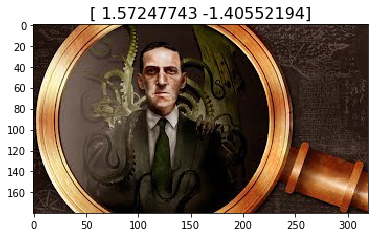

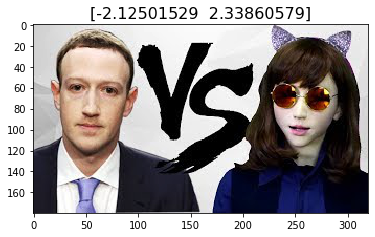

In [62]:
def predict(url):

  img = skimage.img_as_float(io.imread(url))
  plt.figure()
  plt.imshow(img)

  histograms = [exposure.histogram(img[:,:,i], nbins=nbins, normalize=True)[0] for i in range(img.shape[-1])]

  data = np.asarray(histograms).ravel()
  data = torch.Tensor(data).double().to(device)

  out = rede(data)
  plt.title(str(out.detach().cpu().numpy()), fontsize=16)
  plt.show()


peixebabel = url_list[idx[-2]]
predict(peixebabel)
nerdologia = url_list[idx[-149]]
predict(nerdologia)